# Aging Aware with Model Variation
Previously, we optimize the following functional:
$$ \min_\theta \, \int_{t=0}^{1} \; L(\theta(t)) \, {\rm d}t. $$
The optimum is for a specific aging model $\omega$, i.e., we minimized the 
$$ \min_\theta \, \int_{t=0}^{1} \; L(\theta(t,\omega)) \, {\rm d}t. $$
However, we dont know how will the resistance decay, i.e., we should also minimize the loss function w.r.t. aging models with different parameters. That means we need to optimized
$$ \min_\theta \, \int_{\omega}\int_{t=0}^{1} \; L(\theta(t,\omega)) \, {\rm d}t\, p(\omega){\rm d}\omega. $$
The Mento Carlo Approximation is then
$$
\min_{\theta_{\rm init}} \frac{1}{\Omega}\frac{1}{K}\sum_{\omega\in\mathfrak{M}}\sum_{k\in \mathfrak{K} } L \left(\theta[k, \omega]\right),
$$
where $\mathfrak{M}$ is the set of $\Omega$ elements following the distribution $p(\omega)$. $p(\omega)$ is the distributions of parameters of the aging model. We have already obtained these distributions as we modeled the aging decay.

That means we should optimize this problem by
$$
\begin{align}
\theta_{\rm init}&:=\theta_{\rm init} - \alpha\cdot\nabla_{\theta_{\rm init}}\left(\frac{1}{\Omega}\frac{1}{K}\sum_{\omega\in\mathfrak{M}}\sum_{k\in \mathfrak{K} } L \left(\theta[k, \omega]\right)\right)\\
&=\theta_{\rm init} - \frac{\alpha}{\Omega K}\cdot\nabla_{\theta_{\rm init}}\left(\sum_{\omega\in\mathfrak{M}}\sum_{k\in \mathfrak{K} } L \left(\theta[k, \omega]\right)\right)\\
&=\theta_{\rm init} - \frac{\alpha}{\Omega K}\left(\sum_{\omega\in\mathfrak{M}}\sum_{k\in \mathfrak{K} }\nabla_{\theta_{\rm init}} L \left(\theta[k, \omega]\right)\right)
\end{align}
$$

# Get aging model

In [1]:
import importlib
import training
from torch.autograd import Variable
import torch
import pickle
import pNN_aging_aware as pnn
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
sys.path.append(os.path.join(os.getcwd(), 'Aging_Model'))

with open(os.path.join(os.getcwd(), 'Aging_Model', 'exp_aging_model.p'), 'rb') as f:
    age_generator = pickle.load(f)

# Prepare data

## Load data

In [2]:
datapath = os.path.join(os.getcwd(), 'Datasets', 'PMLC',
                        'data_processed', 'Dataset_Pendigits.p')
with open(datapath, 'rb') as f:
    dataset = pickle.load(f)
X = dataset['X'].float()
y = dataset['y']
M, N_features, N_class = X.shape[0], X.shape[1], torch.max(
    torch.unique(y)).item()+1
X.shape, y.shape, M, N_features, N_class

(torch.Size([10992, 16]), torch.Size([10992]), 10992, 16, 10)

## data preprocessing

In [3]:
# normalization
X = X / torch.std(X, axis=0)
X = X - torch.min(X, axis=0)[0]
torch.min(X), torch.max(X)

(tensor(0.), tensor(6.1658))

In [4]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split

# generate tensordataset
dataset = TensorDataset(X, y)

# split
train_rate = 0.6
test_rate = 0.2
M_train = int(M*train_rate)
M_test = int(M*test_rate)
train_data, rest_data = random_split(dataset, [M_train, M-M_train])
test_data, valid_data = random_split(rest_data, [M_test, M-M_train-M_test])
len(train_data), len(test_data), len(valid_data)

(6595, 2198, 2199)

In [5]:
# batch
train_loader = DataLoader(train_data, batch_size=32)
test_loader = DataLoader(test_data, batch_size=len(test_data))
valid_loader = DataLoader(valid_data, batch_size=len(valid_data))

# Definite PNN and AgingAwarePNN

In [6]:
N_Hidden = 15
MyAgedPNN = torch.nn.Sequential(pnn.PNNLayer(N_features, N_Hidden, age_generator),
                                pnn.PNNLayer(N_Hidden, N_Hidden,
                                             age_generator),
                                pnn.PNNLayer(N_Hidden, N_Hidden,
                                             age_generator),
                                pnn.PNNLayer(N_Hidden, N_class, age_generator))
K = 5  # number of time sampling
M = 5  # number of model sampling
optimizer_aged = torch.optim.Adam(MyAgedPNN.parameters(), lr=0.1 / M / K)
MyAgedPNN

Sequential(
  (0): PNNLayer()
  (1): PNNLayer()
  (2): PNNLayer()
  (3): PNNLayer()
)

In [7]:
MyPNN = torch.nn.Sequential(pnn.PNNLayer(N_features, N_Hidden, age_generator),
                            pnn.PNNLayer(N_Hidden, N_Hidden, age_generator),
                            pnn.PNNLayer(N_Hidden, N_Hidden, age_generator),
                            pnn.PNNLayer(N_Hidden, N_class, age_generator))
optimizer = torch.optim.Adam(MyPNN.parameters(), lr=0.01)
MyPNN

Sequential(
  (0): PNNLayer()
  (1): PNNLayer()
  (2): PNNLayer()
  (3): PNNLayer()
)

In [8]:
NN = torch.nn.Sequential(torch.nn.Linear(N_features, N_Hidden), torch.nn.Tanh(),
                         torch.nn.Linear(N_Hidden, N_Hidden), torch.nn.Tanh(),
                         torch.nn.Linear(N_Hidden, N_Hidden), torch.nn.Tanh(),
                         torch.nn.Linear(N_Hidden, N_class))

optimizer_NN = torch.optim.Adam(NN.parameters(), lr=0.005)
celoss = torch.nn.CrossEntropyLoss()
NN

Sequential(
  (0): Linear(in_features=16, out_features=15, bias=True)
  (1): Tanh()
  (2): Linear(in_features=15, out_features=15, bias=True)
  (3): Tanh()
  (4): Linear(in_features=15, out_features=15, bias=True)
  (5): Tanh()
  (6): Linear(in_features=15, out_features=10, bias=True)
)

# Normal NN

In [9]:
from tqdm.notebook import tqdm
for epoch in tqdm(range(200)):
    for x_temp, y_temp in train_loader:
        optimizer_NN.zero_grad()
        prediction = NN(x_temp)
        loss = celoss(prediction, y_temp)
        loss.backward()
        optimizer_NN.step()

    for x_valid, y_valid in test_loader:
        prediction_valid = NN(x_valid)
        p = torch.argmax(prediction_valid, 1)
        pred_y = p.data.numpy().squeeze()
        acc_valid = sum(pred_y == y_valid.numpy()) / y_valid.shape[0]
        loss_valid = celoss(prediction, y_temp)
    if epoch % 10 == 0:
        print(f'| Epoch: {epoch:-5d} | Accuracy: {acc_valid:.5f} | Loss: {loss_valid.data:.5f} |')

  0%|          | 0/200 [00:00<?, ?it/s]

| Epoch:     0 | Accuracy: 0.86852 | Loss: 0.10623 |
| Epoch:    10 | Accuracy: 0.97634 | Loss: 0.01202 |
| Epoch:    20 | Accuracy: 0.97998 | Loss: 0.00168 |
| Epoch:    30 | Accuracy: 0.98180 | Loss: 0.00067 |
| Epoch:    40 | Accuracy: 0.98772 | Loss: 0.00157 |
| Epoch:    50 | Accuracy: 0.98726 | Loss: 0.00223 |
| Epoch:    60 | Accuracy: 0.98681 | Loss: 0.00056 |
| Epoch:    70 | Accuracy: 0.98408 | Loss: 0.00042 |
| Epoch:    80 | Accuracy: 0.98453 | Loss: 0.00017 |
| Epoch:    90 | Accuracy: 0.98408 | Loss: 0.00058 |
| Epoch:   100 | Accuracy: 0.97270 | Loss: 0.00107 |
| Epoch:   110 | Accuracy: 0.97771 | Loss: 0.00144 |
| Epoch:   120 | Accuracy: 0.98362 | Loss: 0.00022 |
| Epoch:   130 | Accuracy: 0.98772 | Loss: 0.00009 |
| Epoch:   140 | Accuracy: 0.98408 | Loss: 0.00115 |
| Epoch:   150 | Accuracy: 0.98453 | Loss: 0.00516 |
| Epoch:   160 | Accuracy: 0.98135 | Loss: 0.00006 |
| Epoch:   170 | Accuracy: 0.98044 | Loss: 0.00046 |
| Epoch:   180 | Accuracy: 0.98590 | Loss: 0.0

# Normal PNN

## Train

In [10]:
m = 0.3
T = 0.1
myloss, myparameter = training.train_normal_pnn(
    MyPNN, train_loader, test_loader, m, T, optimizer, 500)

| Epoch:     0 | Accuracy: 0.62466 | Loss: 0.60312 |
| Epoch:     1 | Accuracy: 0.79436 | Loss: 0.42603 |
| Epoch:     2 | Accuracy: 0.83712 | Loss: 0.31235 |
| Epoch:     3 | Accuracy: 0.86988 | Loss: 0.22320 |
| Epoch:     4 | Accuracy: 0.88990 | Loss: 0.18869 |
| Epoch:     5 | Accuracy: 0.89900 | Loss: 0.16659 |
| Epoch:     6 | Accuracy: 0.90127 | Loss: 0.16105 |
| Epoch:     7 | Accuracy: 0.90992 | Loss: 0.13897 |
| Epoch:     8 | Accuracy: 0.92630 | Loss: 0.13000 |
| Epoch:     9 | Accuracy: 0.93676 | Loss: 0.11078 |
| Epoch:    10 | Accuracy: 0.93358 | Loss: 0.11329 |
| Epoch:    11 | Accuracy: 0.94040 | Loss: 0.10215 |
| Epoch:    12 | Accuracy: 0.94177 | Loss: 0.10160 |
| Epoch:    13 | Accuracy: 0.94586 | Loss: 0.09772 |
| Epoch:    14 | Accuracy: 0.93631 | Loss: 0.11033 |
| Epoch:    15 | Accuracy: 0.94040 | Loss: 0.10346 |
| Epoch:    16 | Accuracy: 0.94359 | Loss: 0.09646 |
| Epoch:    17 | Accuracy: 0.94995 | Loss: 0.08816 |
| Epoch:    18 | Accuracy: 0.94040 | Loss: 0.0

## Early Stop

tensor(0.0653)

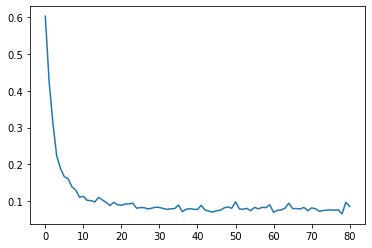

In [11]:
plt.plot(myloss)
best = np.argmin(myloss)
MyPNN.load_state_dict(myparameter[best])
prediction_valid = MyPNN(x_valid)
loss_valid = pnn.LossFunction(prediction_valid, y_valid, m, T)
loss_valid.data

# Aging Aware PNN with Model Variation

## Train

In [ ]:
m = 0.3
T = 0.1
myloss_aged, myparameter_aged = training.train_aged_pnn(MyAgedPNN,
                                                        train_loader, test_loader,
                                                        m, T, M, K, optimizer_aged, 500)

| Epoch:     0 | Accuracy: 0.09600 | Loss: 1.39444 |
| Epoch:     1 | Accuracy: 0.09600 | Loss: 1.39737 |
| Epoch:     2 | Accuracy: 0.09015 | Loss: 1.36158 |
| Epoch:     3 | Accuracy: 0.19642 | Loss: 1.07451 |
| Epoch:     4 | Accuracy: 0.23938 | Loss: 1.08105 |
| Epoch:     5 | Accuracy: 0.27794 | Loss: 0.97450 |
| Epoch:     6 | Accuracy: 0.29800 | Loss: 0.92573 |
| Epoch:     7 | Accuracy: 0.30286 | Loss: 0.96673 |
| Epoch:     8 | Accuracy: 0.33991 | Loss: 0.92250 |
| Epoch:     9 | Accuracy: 0.35538 | Loss: 0.90445 |
| Epoch:    10 | Accuracy: 0.39639 | Loss: 0.83407 |
| Epoch:    11 | Accuracy: 0.40027 | Loss: 0.83334 |
| Epoch:    12 | Accuracy: 0.41621 | Loss: 0.83228 |
| Epoch:    13 | Accuracy: 0.42902 | Loss: 0.85090 |
| Epoch:    14 | Accuracy: 0.44571 | Loss: 0.80123 |
| Epoch:    15 | Accuracy: 0.46187 | Loss: 0.78661 |
| Epoch:    16 | Accuracy: 0.48664 | Loss: 0.75086 |
| Epoch:    17 | Accuracy: 0.46960 | Loss: 0.79217 |
| Epoch:    18 | Accuracy: 0.48543 | Loss: 0.7

## Early Stop

In [ ]:
plt.plot(myloss_aged)
best_aged = np.argmin(myloss_aged)
MyAgedPNN.load_state_dict(myparameter_aged[best_aged])
best_aged

# Save and Read

In [ ]:
# torch.save(MyPNN, f'./simpleclassification/MyPNN_{N_Layer}_{N_Hidden}.pkl')
# torch.save(MyAgedPNN, f'./simpleclassification/MyAgedPNN_{N_Layer}_{N_Hidden}.pkl')

In [ ]:
# MyPNN = torch.load('/simpleclassification/MyPNN.pkl')
# MyAgedPNN = torch.load('/simpleclassification/MyAgedPNN.pkl')

# Evaluation
Evaluate two NNs with 1000 different aging models and over time.

## Test

In [ ]:
import evaluation
import importlib
importlib.reload(evaluation)

test_time = np.linspace(0, 1, 100)
my_aged_acc = []
my_acc = []
my_aged_maa = []
my_maa = []

for omega in range(1000):
    for l in MyAgedPNN:
        l.generate_aging_model()
    for l in MyPNN:
        l.generate_aging_model()
    for test_t in test_time:
        for i in MyAgedPNN:
            i.t = test_t
        for i in MyPNN:
            i.t = test_t

        my_aged_acc.append(evaluation.basic(MyAgedPNN, x_valid, y_valid))
        my_acc.append(evaluation.basic(MyPNN, x_valid, y_valid))

        my_aged_maa.append(evaluation.maa(MyAgedPNN, x_valid, y_valid))
        my_maa.append(evaluation.maa(MyPNN, x_valid, y_valid))
    if omega % 10 == 0:
        print(f'evaluating on the {omega}-th model.')

In [ ]:
my_acc = np.array(my_acc).reshape([1000, 100])
my_aged_acc = np.array(my_aged_acc).reshape([1000, 100])

mean_acc = np.mean(my_acc, axis=0).flatten()
mean_aged_acc = np.mean(my_aged_acc, axis=0).flatten()

std_acc = np.std(my_acc, axis=0).flatten()
std_aged_acc = np.std(my_aged_acc, axis=0).flatten()

## Visualization

In [ ]:
plt.fill_between(test_time, mean_aged_acc-std_aged_acc,
                 mean_aged_acc+std_aged_acc, alpha=0.3, color='red')
plt.fill_between(test_time, mean_acc-std_acc, mean_acc +
                 std_acc, alpha=0.3, color='blue')
plt.plot(test_time, mean_aged_acc, label='aging aware', color='red')
plt.plot(test_time, mean_acc, label='previous', color='blue')
plt.xlabel('normalized time')
plt.ylabel('basic accuracy')
plt.xlim([0, 1])
plt.legend()

In [ ]:
my_maa = np.array(my_maa).reshape([1000, 100])
my_aged_maa = np.array(my_aged_maa).reshape([1000, 100])

mean_maa = np.mean(my_maa, axis=0).flatten()
mean_aged_maa = np.mean(my_aged_maa, axis=0).flatten()

std_maa = np.std(my_maa, axis=0).flatten()
std_aged_maa = np.std(my_aged_maa, axis=0).flatten()

In [ ]:
plt.fill_between(test_time, mean_aged_maa-std_aged_maa,
                 mean_aged_maa+std_aged_maa, alpha=0.3, color='red')
plt.fill_between(test_time, mean_maa-std_maa, mean_acc +
                 std_maa, alpha=0.3, color='blue')
plt.plot(test_time, mean_aged_maa, label='aging aware', color='red')
plt.plot(test_time, mean_maa, label='previous', color='blue')
plt.xlabel('normalized time')
plt.ylabel('measure aware accuracy')
plt.xlim([0, 1])
plt.legend()